In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


In this notebook, we look at the $\mathcal{M}$-open setting, where the generating process is in the span of models.

# Generate a random matrices V, W

For V, assume that 12 variables share a factor structure and the other 8 are noise

In [2]:
N = 50000
D_factor = 10
D_noise = 10
P = 2

V = np.abs(np.random.normal(0.5, 0.5, size=(P,D_factor)))
Z = np.abs(np.random.normal(0.5, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor*2))
X[:, ::2] = np.random.poisson(ZV)
X[:, 1::2] = np.random.poisson(2.,size=(N,D_factor))

In [3]:
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)

In [4]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    #encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True,
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 2


In [5]:
losses = factor.calibrate_advi(
    num_epochs=50, learning_rate=.1)



W0520 13:58:25.061058 4559519168 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 49.46980419524063
Epoch 1: average-batch loss: 32.71920502250535 last batch loss: 30.650924718706126
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 30.330289623855684 last batch loss: 29.91515033740598
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 29.297717098502034 last batch loss: 28.934794600457273
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 28.76281916865853 last batch loss: 28.618106328969503
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 28.469143109937512 last batch loss: 28.396924740166718
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 28.342035861697727 last batch loss: 28.3278169050105
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 28.29272737650959 last batch loss: 28.302444647770397
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 28.26792251340273 last batch loss: 28.276890377684328
Saved a checkpoint: ./.

In [6]:
waic = factor.waic()
print(waic)

{'waic': 205214.45286295697, 'se': 1837.8797392459694, 'lppd': -24310.76774376368, 'pwaic': 78296.4586877148}


In [7]:
intercept_data = az.convert_to_inference_data(
    {
        r"$s_dw_d$": tf.squeeze(
            factor.surrogate_distribution.sample(1000)['w']*factor.norm_factor).numpy().T})

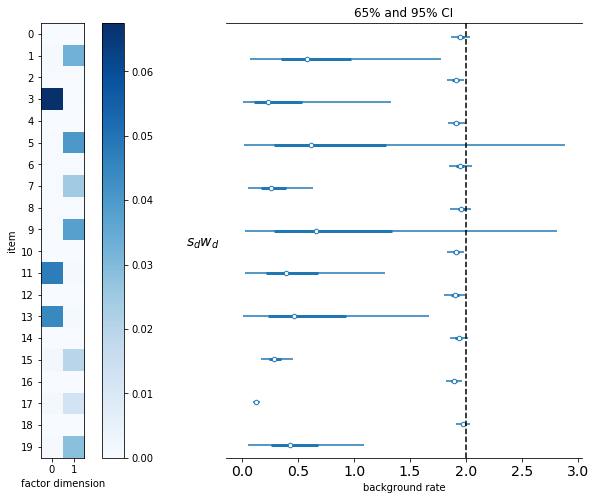

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
D = factor.feature_dim
pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(2.0, linestyle='dashed', color="black")
plt.savefig('mix_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()
